In [1]:
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import pycrs
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from scipy import stats

from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [24]:
crs = pycrs.load.from_file('./PRISM_tmin_stable_4kmD2_19810101_bil.prj')
crs = crs.to_proj4()
crs

'+proj=longlat +datum=NAD83 +ellps=GRS80 +a=6378137.0 +rf=298.257222101 +pm=0 +nodef'

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(621)])
lon = np.array([-125 + i * 0.0416666666667 for i in range(1405)])
Lon, Lat = np.meshgrid(lon, lat)
Lon = Lon[:357, 479:1201]
Lat = Lat[:357, 479:1201]

In [4]:
for yl in range(9):
    DIR = f'./prism/data/{2011+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

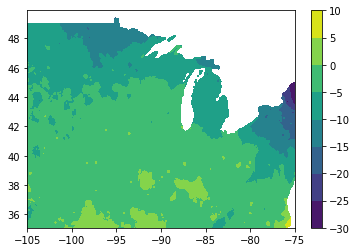

In [3]:
tmin = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = tmin.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)
plt.contourf(Lon, Lat, np.where(a>-1000, a, np.nan))
plt.colorbar()

In [6]:
for yl in range(1):
    tmin = []
    folder = f'./prism/data/{2019+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][18:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        tmin.append(a)
    tmin = np.array(tmin)
    np.savez_compressed(f'./prism/{2011+yl}_tmin', tmin=tmin)

In [5]:
tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
days = np.zeros((y, x))

for yl in range(38):
    tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
    for i in range(90, 152):
        days = np.where(tmin[i, :, :]<0, days+1, days)

days = days / 38.0
days = np.where(mask == 1, days, np.nan)

/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


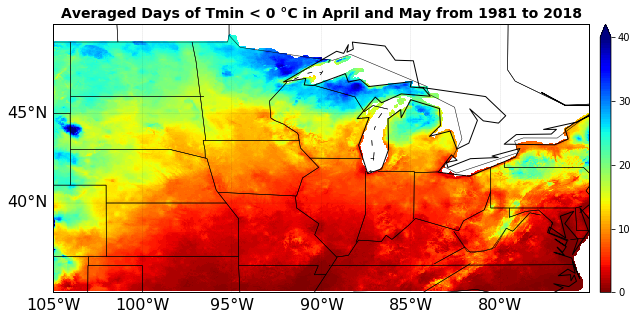

In [32]:
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', lon_0=180, llcrnrlat=35, llcrnrlon=-105, urcrnrlat=50, urcrnrlon=-75, resolution='c')

x, y = m(Lon, Lat)
levels = MaxNLocator(nbins=100).tick_values(0, 40)
cmap = plt.get_cmap('jet_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

m.pcolormesh(x, y, days, cmap=cmap, norm=norm)

m.drawcoastlines()
m.drawmapboundary()  
m.drawstates()
m.drawcountries()  

m.drawparallels(np.arange(40, 50, 5), labels=[1,0,0,0], linewidth=0.1, fontsize=16, dashes=[2,2])
m.drawmeridians(np.arange(-105, -75, 5), labels=[0,0,0,1], linewidth=0.1, fontsize=16, dashes=[2,2])
m.colorbar(ticks=[0,10,20,30,40,50],size='2%', extend='max')

plt.title('Averaged Days of Tmin < 0 \u00b0C in April and May from 1981 to 2018', fontsize = 14, fontweight='bold')
plt.savefig('./plot/freezing_days_prism.png')

In [5]:
tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
days = np.zeros((38, y, x))

for yl in range(38):
    tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
    for i in range(90, 152):
        days[yl, :, :] = np.where(tmin[i, :, :]<0, days[yl, :, :]+1, days[yl, :, :])
    days[yl, :, :] = np.where(mask == 1, days[yl, :, :], np.nan)

X = np.linspace(1, 38, 38)
slope = np.array([[stats.linregress(X, days[:, i, j]).slope for j in range(x)] for i in range(y)])
pvalue = np.array([[stats.linregress(X, days[:, i, j]).pvalue for j in range(x)] for i in range(y)])

In [33]:
# np.argmin(abs(Lon[0,:]+84.267465))  #499
# np.argmin(abs(Lat[:,0]-45.053438))  #117

/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


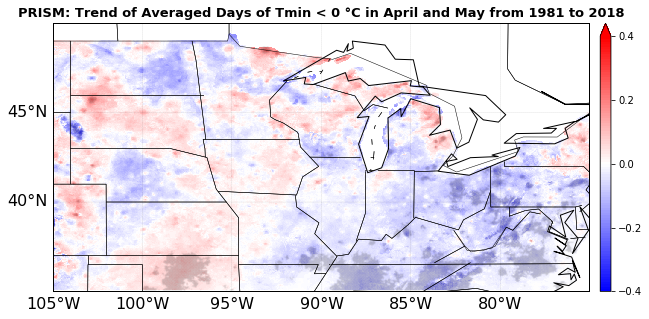

In [37]:
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', lon_0=180, llcrnrlat=35, llcrnrlon=-105, urcrnrlat=50, urcrnrlon=-75, resolution='c')

x, y = m(Lon, Lat)
levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

m.pcolormesh(x, y, slope, cmap=cmap, norm=norm)
m.colorbar(ticks=[-.4, -.2, 0, .2, .4],size='2%', extend='max')

plt.scatter(x, y, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.05)

m.drawcoastlines()
m.drawmapboundary()  
m.drawstates()
m.drawcountries()  

m.drawparallels(np.arange(40, 50, 5), labels=[1,0,0,0], linewidth=0.1, fontsize=16, dashes=[2,2])
m.drawmeridians(np.arange(-105, -75, 5), labels=[0,0,0,1], linewidth=0.1, fontsize=16, dashes=[2,2])


plt.title('PRISM: Trend of Averaged Days of Tmin < 0 \u00b0C in April and May from 1981 to 2018', fontsize = 13, fontweight='bold')
plt.savefig('./plot/freezing_days_trend_45_prism.png')

In [35]:
tmin81 = np.load('./prism/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
days = np.zeros((38, y, x))

for yl in range(38):
    tmin = np.load(f'./prism/{1981+yl}_tmin.npz')['tmin']
    dl = tmin.shape[0]
    for i in range(dl):
        days[yl, :, :] = np.where(tmin[i, :, :]<0, days[yl, :, :]+1, days[yl, :, :])
    days[yl, :, :] = np.where(mask == 1, days[yl, :, :], np.nan)

X = np.linspace(1, 38, 38)
slope_12 = np.array([[stats.linregress(X, days[:, i, j]).slope for j in range(x)] for i in range(y)])
pvalue_12 = np.array([[stats.linregress(X, days[:, i, j]).pvalue for j in range(x)] for i in range(y)])

/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


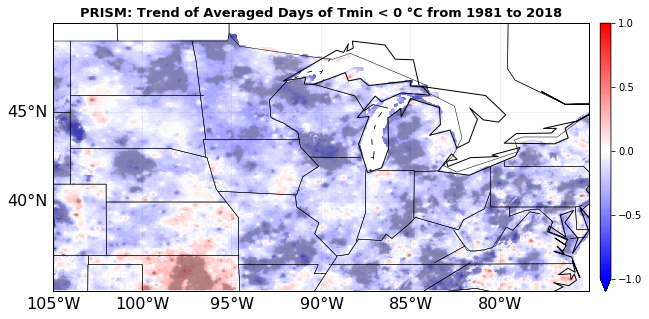

In [38]:
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', lon_0=180, llcrnrlat=35, llcrnrlon=-105, urcrnrlat=50, urcrnrlon=-75, resolution='c')

x, y = m(Lon, Lat)
levels = MaxNLocator(nbins=100).tick_values(-1, 1)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

m.pcolormesh(x, y, slope_12, cmap=cmap, norm=norm)
m.colorbar(ticks=[-1, -.5, 0, .5, 1],size='2%', extend='min')

plt.scatter(x, y, np.where(pvalue_12<0.05, 1, np.nan), 'grey', alpha=.1)

m.drawcoastlines()
m.drawmapboundary()  
m.drawstates()
m.drawcountries()  

m.drawparallels(np.arange(40, 50, 5), labels=[1,0,0,0], linewidth=0.1, fontsize=16, dashes=[2,2])
m.drawmeridians(np.arange(-105, -75, 5), labels=[0,0,0,1], linewidth=0.1, fontsize=16, dashes=[2,2])


plt.title('PRISM: Trend of Averaged Days of Tmin < 0 \u00b0C from 1981 to 2018', fontsize = 13, fontweight='bold')
plt.savefig('./plot/freezing_days_trend_12_prism.png')

In [17]:
# tmin81 = np.load('./prism/1981_tmin.npz')['tmin']
# t, y, x = tmin81.shape
# days = np.zeros((y, x))

# yl = 38
# tmin = np.load(f'./prism/{1981+yl}_tmin.npz')['tmin']
# for i in range(90, 152):
#     days[:, :] = np.where(tmin[i, :, :]<0, days[:, :]+1, days[:, :])
# days[:, :] = np.where(mask == 1, days[:, :], np.nan)
# plt.contourf(days[::-1,:])
# plt.colorbar()